In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
# from torchviz import make_dot
import os, fnmatch
import torchaudio
import sounddevice as sd
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import array
import torch.fft as fft
from CustomDataloader import CustomDataloaderCreator,DataConfig
from Training import Trainer
from tqdm import tqdm

from plottingHelper import compareTwoAudios


import IPython.display as ipd
# from pesq import pesq
import matplotlib.pyplot as plt
# from pystoi import stoi


from scipy.signal import correlate

import librosa
import librosa.display
from scipy.signal.windows import hann

### Helper funcs

In [54]:
print(f'torchaudio backend : {torchaudio.get_audio_backend()}')

def minMaxNorm(wav, eps=1e-8):
    max = np.max(abs(wav))
    min = np.min(abs(wav))
    wav = (wav - min) / (max - min + eps)
    return wav

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

# def printQualityScores(waveform_clean_clip,waveform_noisy_clip, sample_rate):
#     pesq_score_test = pesq(sample_rate, waveform_clean_clip, waveform_clean_clip, 'nb')
#     pesq_score_noisy = pesq(sample_rate, waveform_clean_clip, waveform_noisy_clip, 'nb')

#     stoi_score_test = stoi(waveform_clean_clip, waveform_clean_clip, sample_rate, extended=False)
#     stoi_score_noisy = stoi(waveform_clean_clip,  waveform_noisy_clip, sample_rate, extended=False)

#     print(f'PESQ score for clean (baseline) = {pesq_score_test}')
#     print(f'PESQ score for noisy = {pesq_score_noisy}')
#     print("---------------------------------------------------")
#     print(f'STOI score for clean (baseline) = {stoi_score_test}')
#     print(f'STOI score for noisy = {stoi_score_noisy}')


def compareTwoAudios(input,reconstructed,sampling_rate = 16000):
  
    time = np.arange(len(input))

    # Plot the original signal with transparency
    plt.figure(figsize=(12, 6))
    plt.plot(time, input, label='Original Signal', alpha=0.5)

    # Plot the reconstructed signal on top with transparency
    plt.plot(time, reconstructed, label='Reconstructed Signal', alpha=0.5)

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Comparison of Original and Reconstructed Signals in Time Domain')
    plt.legend()

    # Compute and plot the Fourier transforms
    input_fft = np.fft.fft(input)
    reconstructed_fft = np.fft.fft(reconstructed)
    freq = np.fft.fftfreq(len(input), 1 / sampling_rate)

    plt.figure(figsize=(8, 4))
    plt.subplot(2, 1, 1)
    plt.plot(freq, np.abs(input_fft), label='Original Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Fourier Transform of Original Signal')
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(freq, np.abs(reconstructed_fft), label='Reconstructed Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Fourier Transform of Reconstructed Signal')
    plt.grid()
    plt.tight_layout()

    
    mse = (input - reconstructed) ** 2
    # Plot the correlation
    plt.figure(figsize=(8, 4))
    plt.plot(time, mse,color='red') 
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Square Error between Original and Reconstructed Signals')
    plt.grid()
    plt.show()

    # Calculate the cross-correlation
    correlation = np.correlate(input, reconstructed, mode='full')
    # Create a time array for the correlation
    time = np.arange(-len(input) + 1, len(input))

    # Plot the correlation
    plt.figure(figsize=(12, 6))
    plt.plot(time, correlation)
    plt.xlabel('Time Lag (s)')
    plt.ylabel('Correlation')
    plt.title('Cross-Correlation between Original and Reconstructed Signals')
    plt.grid()
    plt.show()
    

torchaudio backend : sox_io


### Define parameters (Same as model training) + define model

In [55]:
# Set up torch and cuda
dtype = torch.float32
# dtype = torch.float64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor' if torch.cuda.is_available() else 'torch.FloatTensor')

print(device)
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

noisyPath = '/home/ubuntu/OticonStuff/dataset/train'
cleanPath = '/home/ubuntu/OticonStuff/dataset/y_train'
noisy_files_list = fnmatch.filter(os.listdir(noisyPath), '*.wav')
clean_files_list = fnmatch.filter(os.listdir(cleanPath), '*.wav')

# print("Number of noisy files: ", len(noisy_files_list))
# print("Number of clean files: ", len(clean_files_list))
# print("Noisy file: ", noisy_files_list[1])
# print("Clean file: ", clean_files_list[1])

#Corresponds to 512 -> 32ms
frameSize = 512 * 16
#Corresponds to 32 -> 2ms
stride_length = 256 * 16 
speechSampleSize = 48000  
sampleRate = 16000

# Model Input Buffer ( How many frames of size "frameSize" to be fed to the model)
modelBufferFrames = 1

# Forward pass buffer

fft_freq_bins = frameSize // 2 + 1
numOfFFTFrames = (speechSampleSize - frameSize) // (stride_length) + 1

print("Frame Size: ", frameSize)
print("Stride Length: ", stride_length)
print("Speech Sample Size: ", speechSampleSize)
print("Sample Rate: ", sampleRate)
print("Model Buffer Frames: ", modelBufferFrames)
print("Buffer Size: ", frameSize)
print("FFT Frequency Bins: ", fft_freq_bins)
print("Number of FFT Frames: ", numOfFFTFrames)


dataConfig = DataConfig(
    batchSize= 256,
    dtype= dtype,
    device = device,
    learningRate = 0.01,
    frameSize = frameSize, 
    stride_length = stride_length,
    sample_rate = sampleRate,
    duration = 3,
    n_fft = frameSize,
    modelBufferFrames = modelBufferFrames,
    shuffle = True,
    noisyPath = noisyPath,
    cleanPath = cleanPath
)

cuda
Frame Size:  8192
Stride Length:  4096
Speech Sample Size:  48000
Sample Rate:  16000
Model Buffer Frames:  1
Buffer Size:  8192
FFT Frequency Bins:  4097
Number of FFT Frames:  10


In [56]:

class SimpleModel(nn.Module):
    def __init__(self, input_feature_dim, output_feature_dim,dtype = torch.float64):
        super(SimpleModel, self).__init__()
        self.input_feature_dim = input_feature_dim
        self.output_feature_dim = output_feature_dim

        layers = []
        # Layer1
        layers.append(nn.Linear(input_feature_dim, 512,dtype=dtype))
        layers.append(nn.ReLU())

        # Layer2
        layers.append(nn.Linear(512, 512,dtype=dtype))
        layers.append(nn.ReLU())

        # Layer3
        layers.append(nn.Linear(512, self.output_feature_dim,dtype=dtype))
        # layers.append(nn.ReLU())

        self.neuralnet = nn.Sequential(*layers)

    def forward(self, x):
        # x = x.view(-1)
        # print("Input dtype: ", x.dtype)
        output = self.neuralnet(x)
        # output = fft.irfft(output)
        return output
    

fft_freq_bins = dataConfig.frameSize // 2 + 1
input_feature_dim = dataConfig.modelBufferFrames*fft_freq_bins
# output_feature_dim = fft_freq_bins
# output_feature_dim = dataConfig.stride_length
output_feature_dim = fft_freq_bins

model = SimpleModel(input_feature_dim, output_feature_dim,dtype=dataConfig.dtype).to(device)

### Loading in audio

In [57]:
cleanInputFullAudio = []
noisyInputFullAudio = []
filename = "19-198-0003.wav"
speechSampleSize = dataConfig.duration * dataConfig.sample_rate
print("Speech Sample Size: ", speechSampleSize)
noisySpeech,_ = sf.read(os.path.join(dataConfig.noisyPath, filename))
cleanSpeech,_ = sf.read(os.path.join(dataConfig.cleanPath, filename))

#Normalize
noisySpeech = minMaxNorm(noisySpeech)
cleanSpeech = minMaxNorm(cleanSpeech)
print("Noisy Speech Shape: ", noisySpeech.shape)
print("Clean Speech Shape: ", cleanSpeech.shape)

Speech Sample Size:  48000
Noisy Speech Shape:  (247680,)
Clean Speech Shape:  (247680,)


In [58]:
#Clean Audio
ipd.Audio(cleanSpeech, rate=dataConfig.sample_rate)

In [59]:
#Noisy audio
ipd.Audio(noisySpeech, rate=dataConfig.sample_rate)

In [60]:
numSubSamples = int(len(noisySpeech)/speechSampleSize)
for i in range(numSubSamples):
    noisyInputFullAudio.append(noisySpeech[i*speechSampleSize:(i+1)*speechSampleSize])
    cleanInputFullAudio.append(cleanSpeech[i*speechSampleSize:(i+1)*speechSampleSize])

print("Number of Subsamples: ", numSubSamples)

if(dataConfig.dtype == torch.float64) :
    dtype = np.float64
    complexDtype = np.complex128

elif(dataConfig.dtype == torch.float32) :
    dtype = np.float32
    complexDtype = np.complex64

modelInputs = []
phaseInfos = []
for idx, currNoisySample in enumerate(tqdm(noisyInputFullAudio)):
                modelInputBuffer = np.zeros((dataConfig.modelBufferFrames,fft_freq_bins)).astype(complexDtype)
                inbuffer = np.zeros((dataConfig.frameSize)).astype(dtype)
                inbufferClean = np.zeros((dataConfig.frameSize)).astype(dtype)
            
                for i in range(0, len(currNoisySample),dataConfig.stride_length):      
                
                    if(i+dataConfig.stride_length > len(currNoisySample)-1):
                        break

                    #inbuffer is moved : [__s1__+++++++++++++__s2__] -> [+++++++++++++__s2__]
                    inbuffer[:-dataConfig.stride_length] = inbuffer[dataConfig.stride_length:] 
                    #inbuffer is filled with new data: [+++++++++++++__s2__] -> [+++++++++++++----]
                    inbuffer[-dataConfig.stride_length:] = currNoisySample[i : i + dataConfig.stride_length]

                    inbufferClean[:-dataConfig.stride_length] = inbufferClean[dataConfig.stride_length:] 
                    inbufferClean[-dataConfig.stride_length:] = noisyInputFullAudio[idx][i : i + dataConfig.stride_length]
                    
                    #Start up time
                    if i < dataConfig.frameSize:
                        continue
                
                    # ModelInput Creation
                    buffer_array = np.array(inbuffer)
                    windowed_buffer = buffer_array * hann(len(buffer_array), sym=False)
                    frame = np.fft.rfft(windowed_buffer)    

                    phaseInfo = np.angle(frame)

                    modelInputBuffer[:-1, :] = modelInputBuffer[1:, :]
                    modelInputBuffer[-1, :] = frame
                    modelInputs.append(np.array(modelInputBuffer).astype(complexDtype))
                    phaseInfos.append(np.array(phaseInfo))

print("Model Input Shape: ", np.array(modelInputs).shape)
print("Model Input dtype: ", np.array(modelInputs).dtype)

Number of Subsamples:  5


100%|██████████| 5/5 [00:00<00:00, 124.31it/s]

Model Input Shape:  (45, 1, 4097)
Model Input dtype:  complex64


In [61]:
# /home/ubuntu/OticonStuff/Week47_FDtoTD_FS:512_stride:256_MBF:1_LR:0.01_BS:256_Epochs:100500.pt
# /home/ubuntu/OticonStuff/Week47_FDtoTD_FS:4096_stride:2048_MBF:1_LR:0.01_BS:256_Epochs:100_shuffle:True.pt (this had better result)
# /home/ubuntu/OticonStuff/Week47_FDtoTD_FS:4096_stride:512_MBF:1_LR:0.01_BS:256_Epochs:100_shuffle:True.pt (bad)
# /home/ubuntu/OticonStuff/Week47_FDtoTD_FS:512_stride:32_MBF:1_LR:0.01_BS:256_Epochs:100_shuffle:True.pt (just noise)
# /home/ubuntu/OticonStuff/Week47_FDtoTD_FS:4096_stride:2048_MBF:5_LR:0.01_BS:256_Epochs:100_shuffle:True.pt
# /home/ubuntu/OticonStuff/Week47_FDtoTD_FS:8192_stride:4096_MBF:1_LR:0.01_BS:256_Epochs:100_shuffle:True.pt

#Remember to change the configuration as needed in the config cell above
PATH = '/home/ubuntu/OticonStuff/Week47_FDtoTD_FS:8192_stride:4096_MBF:1_LR:0.01_BS:256_Epochs:100_shuffle:True.pt'

model.load_state_dict(torch.load(PATH))
model.eval()

ifftedOutputs = []
for idx,modelInput in enumerate(modelInputs):
    modelInput = torch.from_numpy(modelInput).to(device)
    phaseInfo = torch.from_numpy(phaseInfos[idx]).to(device)
    if(dataConfig.dtype == torch.float32):
        modelInput = torch.abs(modelInput).float()
        # phaseInfo = phaseInfo.float()
    else:
        modelInput = torch.abs(modelInput).double()
        # phaseInfo = phaseInfo.double()
    
    # print("Input shape: ", modelInput.shape)
    reshapedInput = modelInput.view(fft_freq_bins*dataConfig.modelBufferFrames)
    # print("Reshaped Input shape: ", reshapedInput.shape)
    outputMag = model(reshapedInput)

    outputFFTFrame = outputMag * torch.exp(1j*phaseInfo)
    ifftedFrame = fft.irfft(outputFFTFrame)

    # print("Output shape: ", ifftedOutput.shape)
    ifftedOutputs.append(ifftedFrame.cpu().detach().numpy().reshape(dataConfig.frameSize))

### Run inference!

In [62]:
# PATH = '/home/ubuntu/OticonStuff/Week45_FDtoTD_FS:512_stride:256_MBF:1_LR:0.01_BS:256_Epochs:250500.pt'
# model.load_state_dict(torch.load(PATH))
# model.eval()

# ifftedOutputs = []
# for modelInput in modelInputs:
#     modelInput = torch.from_numpy(modelInput).to(device)
#     if(dataConfig.dtype == torch.float32):
#         modelInput = torch.abs(modelInput).float()
#     else:
#         modelInput = torch.abs(modelInput).double()
    
#     # print("Input shape: ", modelInput.shape)
#     reshapedInput = modelInput.view(fft_freq_bins*dataConfig.modelBufferFrames)
#     # print("Reshaped Input shape: ", reshapedInput.shape)
#     ifftedOutput = model(reshapedInput)
#     # print("Output shape: ", ifftedOutput.shape)
#     ifftedOutputs.append(ifftedOutput.cpu().detach().numpy().reshape(dataConfig.frameSize))

# print(f'iffedOutputs shape: {np.array(ifftedOutputs).shape}')

In [63]:
myRealtimeAudioSimulator = []
print(f'noisySpeech.shape = {noisySpeech.shape}')

reconstructedAudioTester = np.zeros_like(noisySpeech)
rtOutputBuffer = np.zeros((dataConfig.frameSize)).astype('float32')

for idx,segment in enumerate(ifftedOutputs):
    addAtIdx = idx*stride_length
    addUntil = addAtIdx + frameSize

    # print(f'For idx = {idx}, np.add.at(reconstructedAudio2, range({addAtIdx}, {addUntil}), segment.lenth = {len(segment)})')
    np.add.at(reconstructedAudioTester, range(addAtIdx, addUntil), segment)
    
    #These indices will not have any dependency on future frames
    if(idx == len(ifftedOutputs) -1):
        myRealtimeAudioSimulator.extend(reconstructedAudioTester[addAtIdx:])
    else:
        myRealtimeAudioSimulator.extend(reconstructedAudioTester[addAtIdx:addAtIdx+stride_length])


print(f'len(myRealtimeAudioSimulator) = {len(myRealtimeAudioSimulator)}')
print(f'myRealtimeAudioSimulator[0][0].dtype = {myRealtimeAudioSimulator[0].dtype}')

noisySpeech.shape = (247680,)
len(myRealtimeAudioSimulator) = 247680
myRealtimeAudioSimulator[0][0].dtype = float64


In [64]:
np_realtimeaudio = np.array(myRealtimeAudioSimulator)
# np_realtimeaudio = minMaxNorm(np_realtimeaudio)
ipd.Audio(np_realtimeaudio, rate=dataConfig.sample_rate)

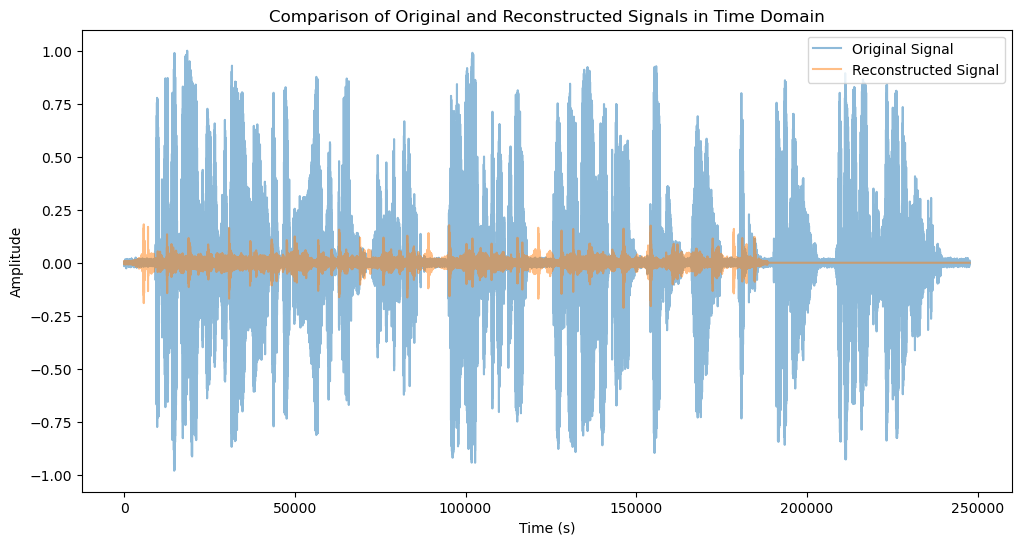

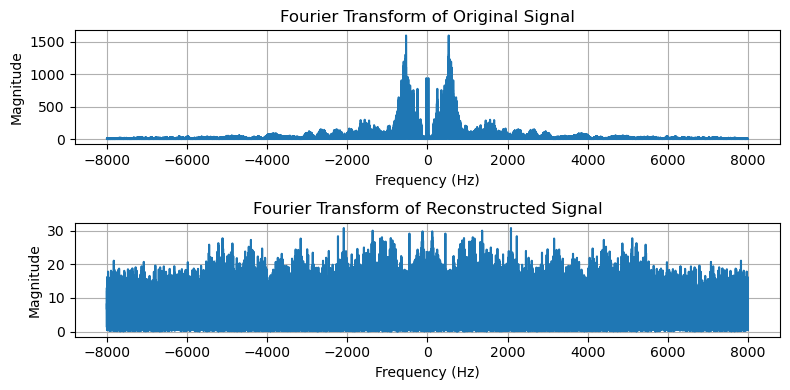

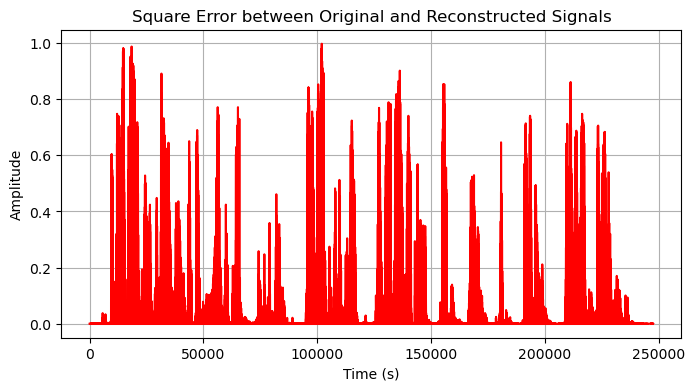

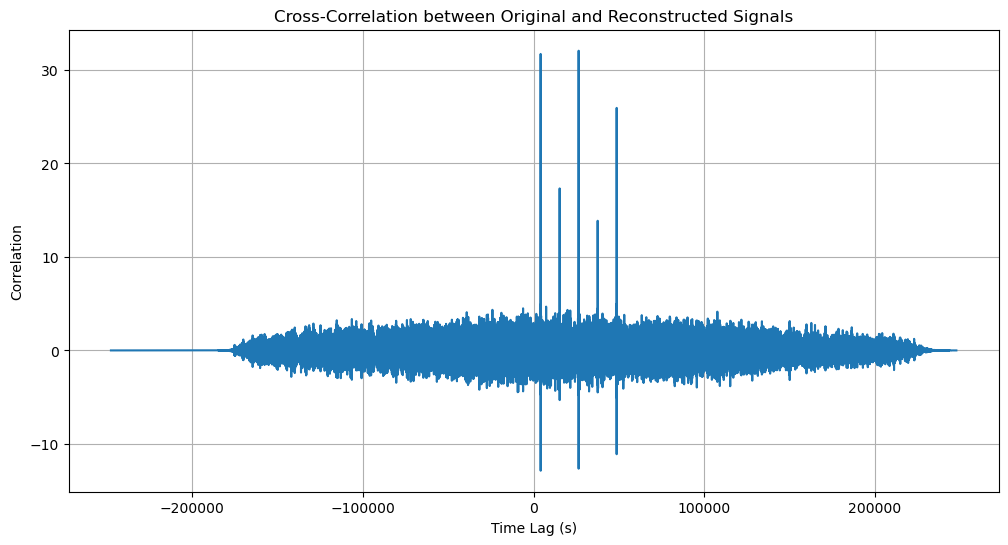

In [65]:
compareTwoAudios(cleanSpeech, np_realtimeaudio)